In [ ]:
##BUILD AND SAVE DATASET##
img_folder = 'images' #establish the directory where all the training / testing images are
from tflearn.data_utils import build_hdf5_image_dataset #module to create data and labels from given images
import os


#Deletes hidden .DS_Store file from sub
try:
    for sub in os.listdir(img_folder):
        if not sub  == '.DS_Store':
            os.remove('{}/{}/.DS_Store'.format(img_folder,sub))
except:
    pass

build_hdf5_image_dataset(img_folder, #create the dataset from the images in img_folder
                         image_shape=(128, 128), #resizes all the images to a uniform size for training
                         mode='folder', #the images are in a folder
                         output_path='dataset.h5', #saves data to a file
                         categorical_labels=True, #create labels for each category, pizza or calzone
                         grayscale=False, #maintain the colors of the images
                         normalize=True) #normalize the images by dividing by 255

##Only need run the above once##

[1,0] == CALZONE
[0,1] == PIZZA
Eg: [Calzone-ness, Pizza-ness]

In [1]:
##LOAD IMAGES##
import h5py
import numpy as np #library for scientific computing
from tflearn.data_utils import shuffle
h5f = h5py.File('dataset.h5', 'r') #open the file 'dataset.h5' in reading mode (like open())
data = h5f['X'] # set the data to X
labels = h5f['Y'] #set the labels to Y
data, labels = shuffle(data,labels) #shuffles the data and labels in parallel

In [2]:
##CONSTRUCTING THE NETWORK##

#Below: import all of the layers and libraries for a TFLearn CNN
from tflearn.layers.core import input_data, fully_connected, dropout
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression

net = input_data(shape=(None,128,128,3)) #create layer to input data, in the same shape as our images (128x128)
net = conv_2d(net, 32, 3, activation='relu',regularizer='L2') # Create first convolutional layer, with 32 neurons, and 
#rectfied linear activation function
net = max_pool_2d(net, 2)
#create first max pool layer, which gets the maximum value from the area created by the filter

net = conv_2d(net, 64, 3, activation='relu',regularizer='L2') #same as above, but w/ 64 neurons
net = max_pool_2d(net, 2)

net = conv_2d(net, 128, 3, activation='relu',regularizer='L2') #same as above, but w/ 128 neurons
net = max_pool_2d(net, 2)

net = conv_2d(net, 256, 3, activation='relu',regularizer='L2') #256 neurons
net = max_pool_2d(net, 2)

net = conv_2d(net, 512, 3, activation='relu',regularizer='L2') #512 neurons
net = max_pool_2d(net, 2)

net = fully_connected(net, 1024, activation='relu') #1024 neurons
net = dropout(net, 0.9) #keep 90% of the outputs from this layer, given by .9 parameter
#helps eliminate chance for overfitting (the neural network memorizing the dataset)

net = fully_connected(net, 2, activation='softmax') #Create fully connected layer, 
#which is representative of our outputs, either calzone, or pizza
#uses softmax activation function, which is commonly used as last layer of NN

net = regression(net, optimizer='adam', learning_rate=1e-4, #perform logistic regression on the output, to try and create a model
#that matches the dataset, even though we have more than one output (why we can't perform linear regression)
                     loss='categorical_crossentropy') #use the categorical crossentropy loss function, used for binary classficiation (2 outputs - pizza or calzone)

In [3]:
##SETUP THE TRAINING##

from tflearn.models import dnn #import library for deep neural network
model = dnn.DNN(net, tensorboard_dir='log',tensorboard_verbose=3) #create the model from the net
#establish the directory to store the logs of the model


In [ ]:
##TRAIN##
model.fit(data, labels, n_epoch=5, #train the model on the data and corresponding labels
           validation_set=.1, #establish set to validate the model on (aka the last 10% of the dataset)
           snapshot_step=200, show_metric=True, run_id='italiaNet') #show the progress of the NN, and give it a name

In [4]:
##SAVING THE MODEL##
MODEL_NAME = 'italiaNet_v4' #give the model a name
model.save('{}.model'.format(MODEL_NAME)) #save the model with the name in the working directory

INFO:tensorflow:/Users/default/Documents/GitHub/italianet/italiaNet_v4.model is not in all_model_checkpoint_paths. Manually adding it.


[ 0.461678    0.53832197]


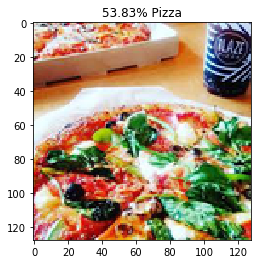

In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt #import library for graphing and displaying images

img = cv2.imread("sample.jpg") #read the image and store it into a variable
orig = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

im = cv2.resize(orig,(128,128))#resize it to pass it into the neural network
im = np.reshape(im,(128,128,3))/255 #normalize (divide by 255)
im = data[0]
orig = data[10]
model_out = model.predict([im])[0] #use the trained model to predict what the image is
print(model_out)
pizzaness = round(model_out[1]*100, 2) #give it a pizza-ness score based on the model output
    
if pizzaness >= 50: #if the pizza-ness is greater than 50%, then its a pizza
    str_label = '{}% Pizza'.format(pizzaness)
else: #otherwise its a calzone
    str_label = '{}% Calzone'.format(100-pizzaness)

plt.imshow(im,interpolation='nearest')
plt.title(str_label) #display the score
plt.show() #display the image

In [9]:
img